## Mongo Database Manager
20200408_1606
- Distribution of all the errors and their count
- Distribution of refdes
- Distribution across board
- Very very dangerous
 
 If you are not sure what it does just write your own

In [ ]:
import pandas as pd
import os, glob, shutil
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pymongo
import json
from bson.objectid import ObjectId
import shutil
import datetime

from IPython.display import display
from IPython.display import Image
from validation_library import FAULT_NAME
print("Setup Complete")

In [ ]:
author="Fazle"

#### Helper Function

In [ ]:
def barplot_distribution(input_df, col='filename', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='str'):
    title="{} {}".format(col, title)
    if (table):
        print(title,"------------------")
        print(input_df.groupby(col)[col].count())
    plt.figure(figsize=(fig_dw, fig_dh))
    plt.title(title)
    if dtype=='str': x_values = [(x.replace(",", "\n\n")).replace(" ", "\n") for x in input_df.groupby(col)[col].count().index]
    else:x_values = [x for x in input_df.groupby(col)[col].count().index]
    sns.barplot(x=x_values, y=input_df.groupby(col)[col].count().values)


In [ ]:
def createDirectory(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        print ("Creating {}".format(path))
    return path

#### Replace NULL with OK

In [5]:
def replace_noerror(df):
    df.loc[pd.isnull(df.error), "error"]= FAULT_NAME['ok']
    return df

### Validation function

In [6]:
# *************************************************************
#   Author       : HM Fazle Rabbi
#   Description  : Validation invalid coordinates in x1, y1...
#   Date Modified: 
#   Copyright © 2000, MV Technology Ltd. All rights reserved.
# *************************************************************
def validate_x1y1x2y2 (x1,x2,y1,y2, xmin, xmax, ymin, ymax, msg):
    success = True
    if ((x1 > xmax) or (x2 > xmax)):
        success = False
#         print("Failed: ((x1 > xmax) or (x2 > xmax))")
    if ((x1 < xmin) or (x2 < xmin)):
        success = False
#         print("Failed: ((x1 < xmin) or (x2 < xmin))")

    if ((y1 > ymax) or (y2 > ymax)):
        success = False
#         print("Failed: ((y1 > ymax) or (y2 > ymax))")
    if ((y1 < ymin) or (y2 < ymin)):
        success = False
#         print("Failed: ((y1 < ymin) or (y2 < ymin))")

    if ((x2 - x1) <= 1 ):
        success = False
#         print("Failed: (x2 <= x1)")
    if ((y2 - y1) <= 1):
        success = False
#         print("Failed: (y2 <= y1)")

    if not success:
#         print("Invalid coordinate:\n\t{} {} {} {} \n\t{} {} {} {}".format(x1,x2,y1,y2, xmin, xmax, ymin, ymax))
#         print(msg)
        pass
    return success

# *************************************************************
#   Author       : HM Fazle Rabbi
#   Description  : Validation invalid coordinates in x1, y1...
#   Date Modified: 
#   Copyright © 2000, MV Technology Ltd. All rights reserved.
# *************************************************************
def validate_cxcy (cx, cy, xmin, xmax, ymin, ymax, msg):
    success = True
    if ((cx > xmax) or (cy > ymax)) :
        success = False
#         print("Failed: (cx > xmax) or (cy > ymax) ")
    if ((cx < xmin) or (cy < ymin)):
        success = False
#         print("Failed:  ((cx < xmin) or (cy < ymin))")
        if not success:
            print(msg)
    return success

### Create Mongo db

In [7]:
db_name="Aoi_Boards-00"
collection_name="Aoi_Boards_2020_E01"
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient[db_name]

In [1]:
# WARNING
# Delete old database
if 0:
    mydb[collection_name].drop()

In [10]:
# Get collection
myboard_col = mydb[collection_name]
print("myboard_col.count():\t", myboard_col.estimated_document_count())

myboard_col.count():	 0


In [11]:
def addDfToDatabase(df, my_col, bname=None):
    for i, row in df.iterrows():

        # Board info
        path = os.path.normpath(row['path'])
        dir_list=path.split(os.sep)
        board_name = bname.strip()
        tile_id=dir_list[-2].strip()
        if(dir_list[-3] != 'Tiles'):
            print("ERROR: Invalid path entry detected! \n", path)
            sys.exit()
        path=board_name+'/'+'Tiles/'+str(tile_id)+"/"+dir_list[-1]
        
        #Error
        error_msg=row['error'].upper()
        if  error_msg=="OK": 
            error_count = 0 
        else: 
            error_count = 1 
    

        # Search area
        searchArea = json.loads(row['searchArea'])  
        if not (validate_cxcy (searchArea[4],searchArea[5], searchArea[0],searchArea[2],searchArea[1],searchArea[3], "[ERROR]: Invalid body center location!")):
            if (error_count):
                error_msg=error_msg + "," +  FAULT_NAME['mismatchsearchareacenter'] #",MISMATCH SEARCHAREA CENTER" 
            else: 
                error_msg=FAULT_NAME['mismatchsearchareacenter']
            error_count =error_count+1
                
        if not (validate_x1y1x2y2 (searchArea[0],searchArea[2],searchArea[1],searchArea[3], 0,2048, 0,2048, "[ERROR]: Invalid search area!")):
            if (error_count):
                error_msg=error_msg + "," + FAULT_NAME['outofboundsearcharea'] #",OUTOFBOUND SEARCHAREA" 
            else: 
                error_msg=FAULT_NAME['outofboundsearcharea'] 
            error_count =error_count+1

            
        # Body
        body = json.loads(row['body_dims'])
        if not (validate_x1y1x2y2 (body[0],body[2],body[1],body[3], searchArea[0],searchArea[2],searchArea[1],searchArea[3], "[ERROR]: Invalid body dimension or location!")):
            if (error_count):
                error_msg=error_msg +"," + FAULT_NAME['invalidbodydimensions'] #",INVALID BODY DIMENSIONS" 
            else: 
                error_msg=FAULT_NAME['invalidbodydimensions'] 
            error_count =error_count+1

        if not (validate_cxcy (body[7],body[8], body[0],body[2],body[1],body[3], "[ERROR]: Invalid body center location!")):
            if (error_count):
                error_msg=error_msg+",MISMATCH BODY CENTER" 
            else: 
                error_msg="MISMATCH BODY CENTER" 
            error_count =error_count+1
            
        # Pin
        pin_array=[]
        if(row['pins_dims']):
            data_list = json.loads(row['pins_dims'])
            if(data_list):
                for data in data_list:
                    if (max(data) > 0):
                        _temp = {
                            "x1":  data[0],
                            "y1":  data[1],
                            "x2":  data[2],
                            "y2":  data[3]
                        }
                        if (validate_x1y1x2y2 (_temp["x1"],_temp["x2"],_temp["y1"],_temp["y2"], searchArea[0],searchArea[2],searchArea[1],searchArea[3], "[ERROR]: Invalid pin dimension or location!")):
                            pin_array.append(_temp)
                        else:
                            if (error_count):
                                if  FAULT_NAME['missingpins'] not in error_msg: error_msg=error_msg + "," + FAULT_NAME['missingpins']
                            else: 
                                error_msg=FAULT_NAME['missingpins']
                            error_count =error_count+1

        # Create Document
        document = {
            'board_name':board_name,
            'tile_id': tile_id,
            'path':path,
            'refDes ':row.refDes,
            'package':row.package,
            'package':row.package,
            'search_area':{
                "x1":  searchArea[0],
                "y1":  searchArea[1],
                "x2":  searchArea[2],
                "y2":  searchArea[3],
                "cx":  searchArea[4],
                "cy":  searchArea[5]
            },
            'body_dim':{
                "x1":  body[0],
                "y1":  body[1],
                "x2":  body[2],
                "y2":  body[3],
                "width":  body[4],
                "height":  body[5],
                "ori":  body[6],
                "cx":  body[7],
                "cy":  body[8]
            },
            'pins':{
                'len': len (pin_array),
                'dim_list':pin_array
            },
            'ocv_dims':row['ocv_dims'],
            'type_rep':row['type_rep'],
            'error':error_msg.split(',')[-1],
            'error_stack': error_msg.split(','),
            'tile_files_info':{
                'total_channels':-1,
                'channel_list':[],
                'pgm_exist':-1,
                'rgb_exist':-1,
                'tdev':-1
            },
            'date_created':datetime.datetime.now().strftime("%Y%m%d_%H%M"),
            'date_modified':datetime.datetime.now().strftime("%Y%m%d_%H%M"),
            'author': author

        }
        my_col.insert_one (document)
        #print(document)




## WARNING
- Makes changes to database

### Write to collection 
- Only updates the database
- Doesnot write anything to disk

In [12]:
board_basedir="D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01"
boardname_list=os.listdir(board_basedir)
print("Start loading {} boards...".format(len(boardname_list)))
# boardname_list=[
# #     'AGG5500-61003-R3-T',
#     "B8PA_LEFT_90121351_B125"
# ]


def readboardlist_tomongodb(boardname_list, mycol):
    for bname in boardname_list:
        path='{}/{}/output/updated_all_tiles.csv'.format(board_basedir,bname)
        print("Analysing: ",path)
        if (os.path.isfile(path)):
            df = pd.read_csv(path)
            df = replace_noerror(df)
            try:
                addDfToDatabase(df, mycol, bname)       
            except:
                print("Failed ", bname)
        else:
            print("Invalid file {}".format(path))
            raise FileExistsError("Missing {}".format(path))
    print    ("\nLoading all board completed") 
        

if 0: #WARNING: Use extreme caution while upadating database
        readboardlist_tomongodb(boardname_list, myboard_col)      

Start loading 34 boards...
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/03015_#2/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/03015_#3/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/03015_#5/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/03022TNL-TOP-A/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/03022UMXTA/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/100642-04-BOT-D/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/12067-B/output/updated_all_tiles.csv
Analysing:  D:/FZ_WS/JyNB/Yolo_LD/Tf_Yolov3/LD_Files/Boards/Aoi_Boards_2020_E01/2018-09-139/output/updated_all_tiles.csv
Analysing:  

----------------------------------------------------------

## Analyse
- Distribution of refdes
- Distribution across board

In [13]:
print("myboard_col.count():\t", myboard_col.estimated_document_count(),"\n")
print(myboard_col.find_one(),"\n")

myboard_col.count():	 61569 

{'_id': ObjectId('5eb8c75ee9019099aa005baa'), 'board_name': '03015_#2', 'tile_id': '0', 'path': '03015_#2/Tiles/0/03015_#2_RGB.jpg', 'refDes ': 'r1', 'package': 'BGA', 'search_area': {'x1': 2359, 'y1': 1367, 'x2': 2393, 'y2': 1427, 'cx': 2376, 'cy': 1397}, 'body_dim': {'x1': 2366, 'y1': 1376, 'x2': 2384, 'y2': 1411, 'width': 18, 'height': 35, 'ori': 0, 'cx': 2375, 'cy': 1393}, 'pins': {'len': 0, 'dim_list': []}, 'ocv_dims': 0, 'type_rep': 'b200vert', 'error': 'OUTOFBOUND SEARCHAREA', 'error_stack': ['MISSING', 'OUTOFBOUND SEARCHAREA'], 'tile_files_info': {'total_channels': -1, 'channel_list': [], 'pgm_exist': -1, 'rgb_exist': -1, 'tdev': -1}, 'date_created': '20200511_1132', 'date_modified': '20200511_1132', 'author': 'Fazle'} 



package count distribution ------------------
package
BGA               1175
CAPACITOR_NL        18
CC               32807
COIL_IND           135
COIL_INDUCTOR      371
CR               17393
CRNETWORK          494
CRYSTAL             89
DPAK                24
ECAP                46
INDUCTOR           161
Inductor            25
LED                 83
MELF                20
QFN                668
QFP                 29
SOD_FLAT           573
SOD_GULL             2
SOD_J               67
SOIC               697
SOT                835
SOT223_4L           18
TANTALAM           377
unknown           5462
Name: package, dtype: int64


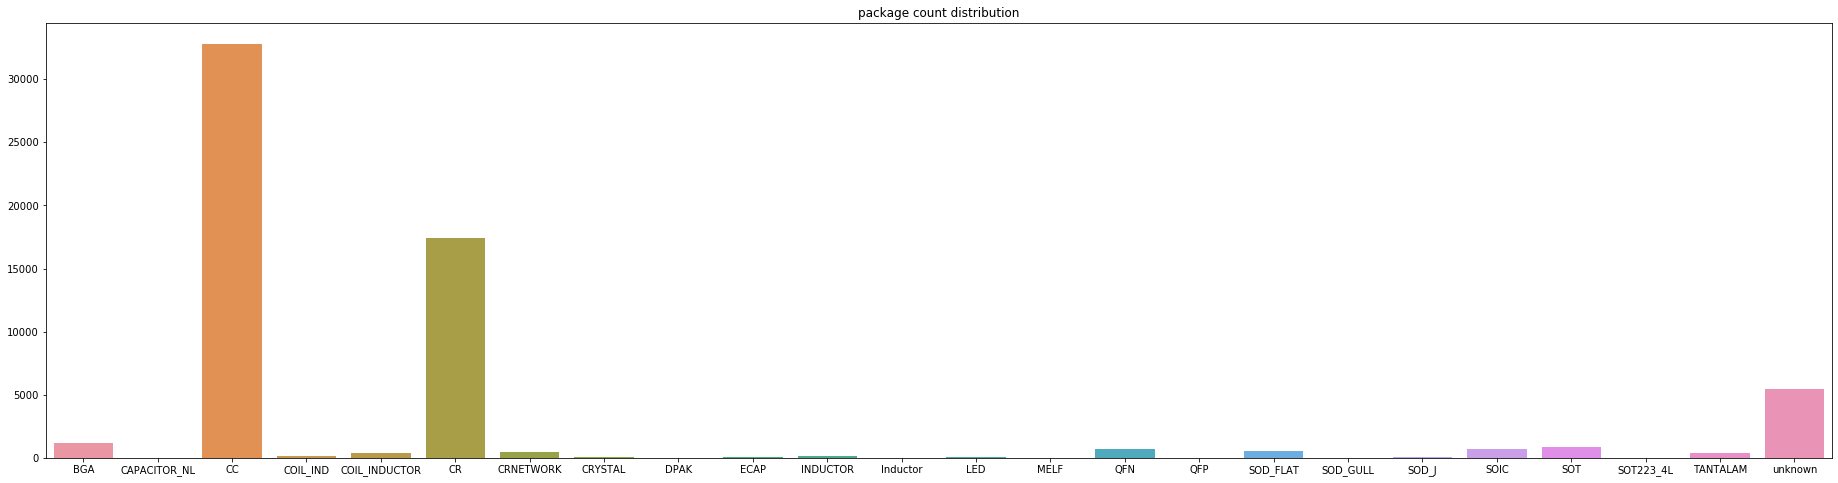

In [14]:
# Package count distribution in whole database
_df=pd.DataFrame(myboard_col.find({},{'package':True}))
barplot_distribution(_df, col='package',  title="count distribution", table=True)

board_name  based total refdes distribution ------------------
board_name
03015_#2                          246
03015_#3                          246
03015_#5                          246
03022TNL-TOP-A                   3768
03022UMXTA                       3429
100642-04-BOT-D                  1443
12067-B                          4800
2018-09-139                      1054
2AB017-1V40CA-4961243             828
73-13258-07_C0_TOP_JMX            815
903057B-01                        712
AGI-VR-G2581-61007-panelized     1572
C7H05-SATM001-0B                 1733
CIE_NTK761AA_420_RL008_bot_3D    4800
E387503100_A0RC-CS                643
EPDFXXX21MS-V4                    622
ERROA1283711_2R1G_01_B_90        4716
ERROA1283711_2R1G_01_T_90        2135
ERROA1285805_1R1D_01_T_90        3513
F1_PMLE5082A_B_REVA              3960
FID8250_MF_DSDA_rev8_Tpan         990
FID8868_Yuma_DUT_T                  8
FMC-GN31-MB-679-T                 952
G29836-013_T                      720
G70000314_PEQ5

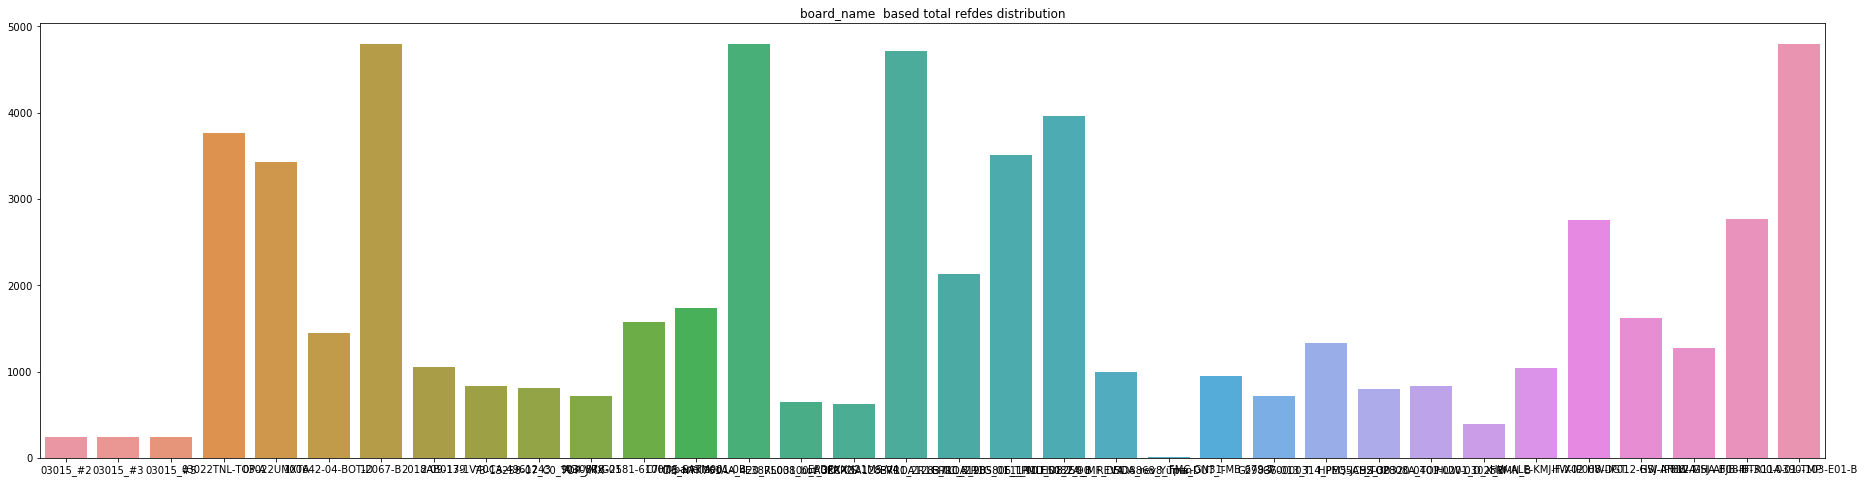

In [15]:
# Package count distribution in whole database by board_name
_df=pd.DataFrame(myboard_col.find({},{'board_name':True}))
barplot_distribution(_df, col='board_name',  title=" based total refdes distribution", table=True)

### Board info graph analysis
- Distribution of all the errors and their count


##### Csv Error analysis

error - Distribution ------------------
error
BADJOINT                     553
BILLBOARD                    162
COPLANARITY                   19
DAMAGED                        3
EXTRA                         28
FLIPPED                       14
INVALID BODY DIMENSIONS     6298
LIFTED                         1
MISSING                      435
MISSING PINS                 791
OCV                          934
OFFSET                       638
OK                         25467
OUTOFBOUND SEARCHAREA      26114
PASTE                          2
POLARITY                      32
SKEW                          78
Name: error, dtype: int64


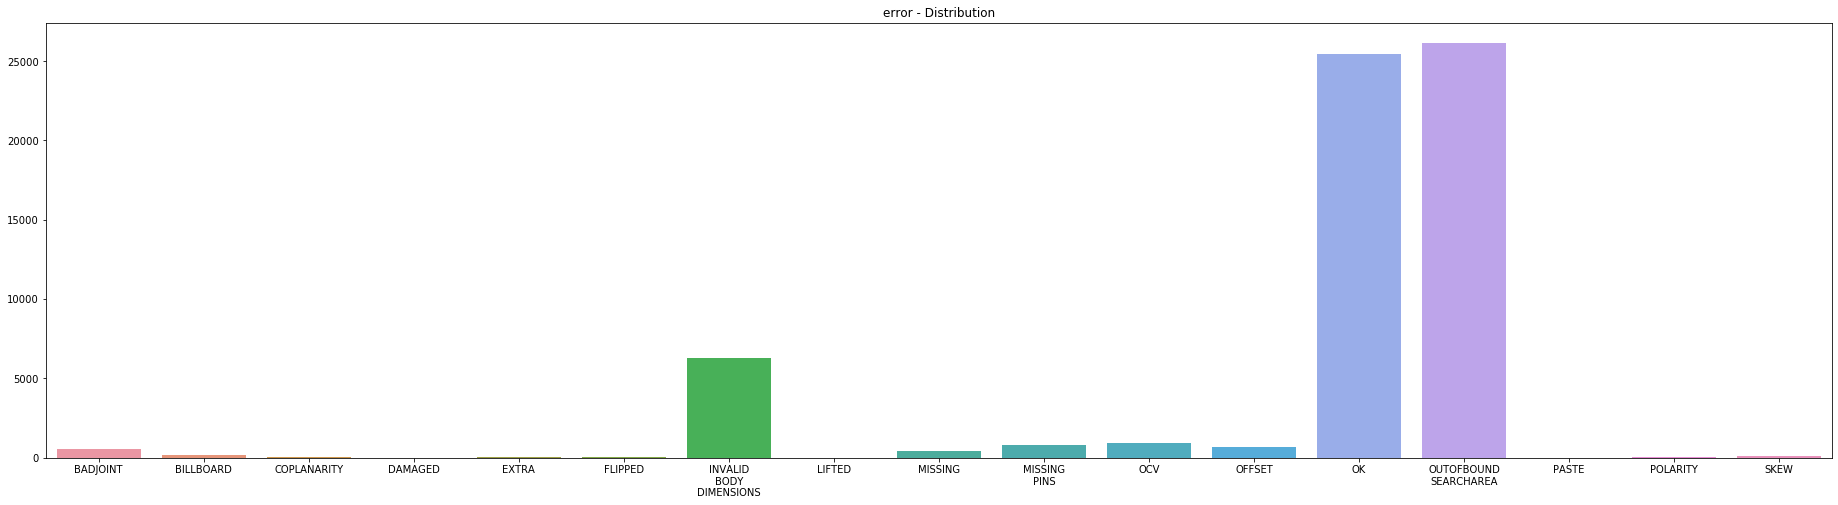

In [16]:
_df=pd.DataFrame(myboard_col.find({},{'error':True}))
barplot_distribution(_df, col='error',  title="- Distribution", table=True)

len of number of error in error stack ------------------
len
1    27473
2     6928
3      932
4      769
Name: len, dtype: int64


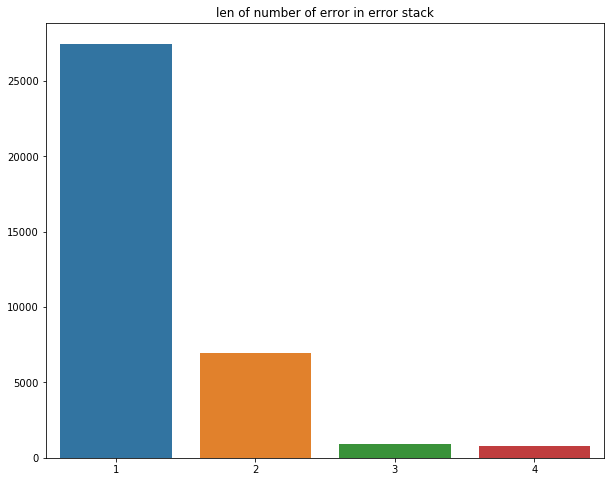

In [17]:
# Error frequency per refdes
myquery={ "error": { "$ne": "OK" } }
_df=pd.DataFrame(myboard_col.find(myquery,{'error_stack':True, '_id':False}))
_df['len']=_df['error_stack'].apply(len)
barplot_distribution(_df, col='len',  title="of number of error in error stack", fig_dw=10, table=True, dtype='int')